## План

1. S modeling

2. T modeling

3. X learner

4. R learner

In [3]:
from pathlib import Path
import sys
 
if sys.argv:
    sys.path.insert(0, str(Path('/Users/ogrobertino/UpliftModelingResearch/').resolve()))
%load_ext autoreload
%autoreload 2
import pandas as pd
from src.datasets import sample_features, TorchDataset, NumpyDataset

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.weightstats import ztest

from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm

pd.options.display.max_rows = 200
pd.options.display.max_colwidth = 200
from sklearn.metrics import roc_auc_score

def local_read(path):
    return pd.DataFrame(yt.read_table(path))

import lightgbm as lgb
import causalml
import causalml.metrics as cmetrics
import causalml.inference.tree as ctree
import causalml.inference.meta.tlearner as tlearner
import causalml.inference.meta.slearner as slearner
import causalml.inference.meta.rlearner as rlearner
import causalml.inference.meta.xlearner as xlearner
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from catboost import CatBoostClassifier
# import causalml.inference.meta.rlearner as rlearner
# import causalml.inference.meta.xlearner as xlearner
# import causalml.inference.meta.drlearner as drlearner

Failed to import duecredit due to No module named 'duecredit'


In [13]:
def load_train_test(ds_name, features_precent):
    features_percent = 100

    path_to_data_train = f'../data/{ds_name}/{features_percent}/train.tsv'
    path_to_data_test = f'../data/{ds_name}/{features_percent}/test.tsv'
    train = NumpyDataset(path_to_data_train)
    test = NumpyDataset(path_to_data_test)

    return train, test

In [49]:
def train_model_causal(model, train):
    tmodel.fit(
        X=train.data.loc[:, cols_features].values,
        treatment=train.data.loc[:, col_treatment].values,
        y=train.data.loc[:, col_target].values,
    )
    return tmodel

In [15]:
def apply(model, data, cols_features, col_treatment, col_target):
    scores = data.copy(deep=True)
    scores['score'] = model.predict(scores.loc[:, cols_features])
    return scores[['score', col_treatment, col_target]]

In [20]:
train, test = load_train_test(ds_name='lazada', features_precent=100)

In [5]:
col_treatment = "treatment"
col_target = "target"
cols_features = train.data.drop(["treatment", 'target'], axis=1).columns

In [22]:
tmodel.fit??

Signature: tmodel.fit(X, treatment, y, p=None)
Source:   
    @ignore_warnings(category=ConvergenceWarning)
    def fit(self, X, treatment, y, p=None):
        """Fit the inference model

        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
        """
        X, treatment, y = convert_pd_to_np(X, treatment, y)
        check_treatment_vector(treatment, self.control_name)
        self.t_groups = np.unique(treatment[treatment != self.control_name])
        self.t_groups.sort()
        self._classes = {group: i for i, group in enumerate(self.t_groups)}
        self.models_c = {group: deepcopy(self.model_c) for group in self.t_groups}
        self.models_t = {group: deepcopy(self.model_t) for group in self.t_groups}

        for group in self.t_groups:
            mask = (treatment == group) | (treatment == self.control_name)
          

In [50]:
tmodel = tlearner.BaseTClassifier(
    learner=lgb.LGBMClassifier(),
    control_learner=lgb.LGBMClassifier(),
    treatment_learner=lgb.LGBMClassifier(),
    control_name=0
)
tmodel = train_model_causal(tmodel, train)

/Users/ogrobertino/new_diploma/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 6810, number of negative: 714379
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9345
[LightGBM] [Info] Number of data points in the train set: 721189, number of used features: 82
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.009443 -> initscore=-4.653022
[LightGBM] [Info] Start training from score -4.653022


/Users/ogrobertino/new_diploma/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 11638, number of negative: 193842
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9556
[LightGBM] [Info] Number of data points in the train set: 205480, number of used features: 82
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.056638 -> initscore=-2.812768
[LightGBM] [Info] Start training from score -2.812768


In [29]:
pred_tmodel = apply(tmodel, test.data, cols_features, col_treatment, col_target)

In [26]:
cmetrics.auuc_score(
    pred_tmodel, 
    outcome_col=col_target, 
    treatment_col=col_treatment, 
)

score     0.508483
Random    0.495192
dtype: float64

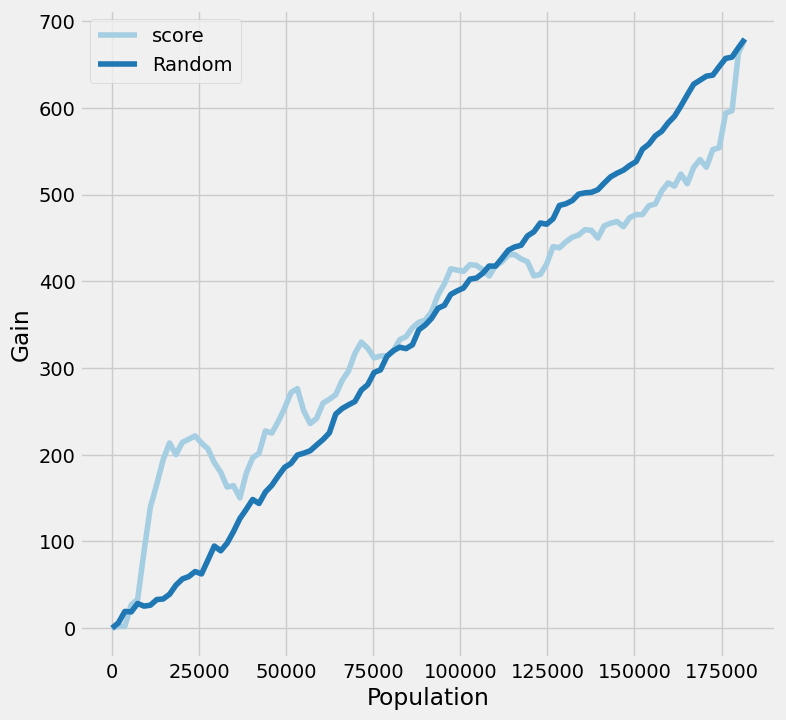

In [30]:
cmetrics.plot_gain(
    pred_tmodel,
    treatment_col=col_treatment,
    outcome_col=col_target,
)

In [31]:
tmodel.__class__

causalml.inference.meta.tlearner.BaseTClassifier

1. Сделать сохранение бинарей модели по папкам
2. Проверить что бинаоь загружается
3. Сделать байесовский поиск по гиперпараметрам
4. Сохранить таблицу в следующем формате:
   * Назваине модели/класса (. __ class __)
   * Конфиг (гиперпараметры)
   * Название датасета
   * Процент фичей
   * Путь до бинаря модели
   * Время работы (latency)
   * Размер бинаря?
   * AUUC на тесте
   * precision@[5, 100] на тесте

In [60]:
tmodel.models_c[1].feature_importances_

array([ 34, 112, 110,  33,  71,  89,  43,   5,  76,  49,  28,  29,  95,
        71,  59, 119,  77,  40,   3,  97,  70, 119, 101,  92, 165, 140,
         0,   0,  62,  40,  13, 105, 108,   0,  78,  17,   8,   4,   5,
         4,   4,   3,  10,   4,   1,  88,   4,   0,   8,  14,   2,   8,
         5,   4,   4,   4,   0,  10,  16,  11,   1,   9,   3,  14,   2,
         0,   0,  22,   0,   0,   0,   0,   0,  13,   2,   0,   0,  76,
        59,  51,  72,  37,  68], dtype=int32)

In [69]:
model

LGBMClassifier()

In [104]:
from catboost import CatBoostClassifier

In [106]:
# CatBoostClassifier??

In [108]:
# tlearner??

In [91]:
from catboost import CatBoostClassifier

tmodel = tlearner.BaseTClassifier(
    learner=CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, verbose=0),
    control_learner=CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, verbose=0),
    treatment_learner=CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, verbose=0),
    control_name=0
)
tmodel = train_model_causal(tmodel, train)

In [92]:
pred_tmodel = apply(tmodel, test.data, cols_features, col_treatment, col_target)
cmetrics.auuc_score(
    pred_tmodel, 
    outcome_col=col_target, 
    treatment_col=col_treatment, 
)

score     0.669389
Random    0.495192
dtype: float64

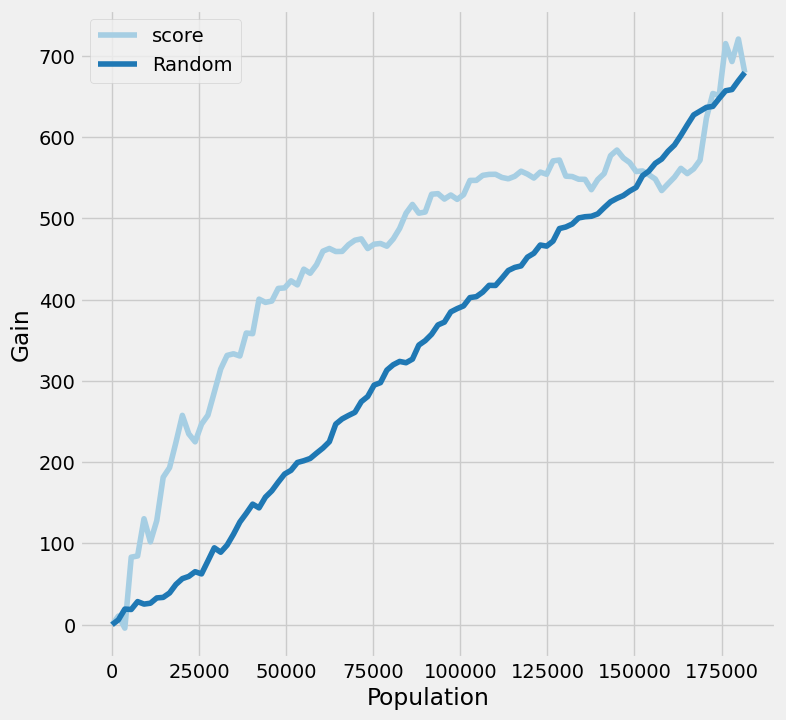

In [93]:
cmetrics.plot_gain(
    pred_tmodel,
    treatment_col=col_treatment,
    outcome_col=col_target,
)

In [96]:
tmodel.models_c[1].feature_importances_

array([1.17960188e+00, 8.28112502e+00, 1.27217180e+00, 4.94943431e-01,
       1.96921149e-01, 2.85280256e+00, 2.76681043e-01, 2.74618496e-01,
       1.13951945e+00, 1.03147974e+00, 1.10029236e+00, 6.42778632e-01,
       4.94504555e+00, 1.47102152e+00, 6.57318346e-01, 1.05748954e+00,
       7.30978695e-02, 8.19514826e-01, 6.48646811e-02, 3.43119597e+00,
       1.03096527e+01, 2.53636053e+00, 2.80650193e+00, 1.69861495e+00,
       2.18138354e+01, 7.16230347e-01, 8.12945033e-01, 1.91821069e+00,
       7.60879106e-01, 2.47875895e+00, 1.02251616e+00, 9.37714902e-01,
       1.87458132e+00, 1.78371254e-01, 8.17827157e-01, 3.25145775e-01,
       6.47232478e-02, 5.18220536e-01, 2.15320477e-01, 1.46860557e-01,
       0.00000000e+00, 6.09772870e-02, 1.01898167e-01, 1.17058379e-02,
       4.76263777e-02, 3.78841227e+00, 0.00000000e+00, 0.00000000e+00,
       2.40465943e-01, 2.61770888e+00, 1.07808469e-03, 0.00000000e+00,
       9.33022404e-02, 2.38197477e-02, 0.00000000e+00, 5.77763804e-02,
      

In [97]:
model = tmodel.models_c[1]
importance_df = pd.DataFrame({
    'feature': model.feature_name_,
    'importance': model.feature_importances_
})

# Оставить только важные признаки
important_features = importance_df[importance_df['importance'] > 10]['feature'].tolist()

AttributeError: 'CatBoostClassifier' object has no attribute 'feature_name_'

In [ ]:
model = tmodel.models_c[1]
importance_df = pd.DataFrame({
    'feature': model.feature_name_,
    'importance': model.feature_importances_
})

# Оставить только важные признаки
important_features = importance_df[importance_df['importance'] > 10]['feature'].tolist()

# Переобучить модель на этих признаках
X_train_reduced = X_train[important_features]
X_test_reduced = X_test[important_features]

# Обучить новую модель
model_reduced = lgb.LGBMClassifier(**params)
model_reduced.fit(X_train_reduced, y_train, eval_set=[(X_test_reduced, y_test)])

Прунинг моделей:
1. CCP у склерновского бустинга
2. https://inria.github.io/scikit-learn-mooc/python_scripts/ensemble_hist_gradient_boosting.html
3. у катбуста CatBoostPruningCallback

In [70]:
model = tmodel.models_c[1]
importance_df = pd.DataFrame({
    'feature': model.feature_name_,
    'importance': model.feature_importances_
})

# Оставить только важные признаки
important_features = importance_df[importance_df['importance'] > 10]['feature'].tolist()

# Переобучить модель на этих признаках
X_train_reduced = X_train[important_features]
X_test_reduced = X_test[important_features]

# Обучить новую модель
model_reduced = lgb.LGBMClassifier(**params)
model_reduced.fit(X_train_reduced, y_train, eval_set=[(X_test_reduced, y_test)])

NameError: name 'X_train' is not defined

In [89]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from causalml.inference.meta import BaseDRLearner
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# (1) Generate a Synthetic Dataset
# Here we simulate some data for the purposes of causal inference
np.random.seed(42)
n_samples = 5000

# Simulate features
X = pd.DataFrame({
    'feature_1': np.random.normal(0, 1, n_samples),
    'feature_2': np.random.normal(0, 1, n_samples),
    # 'categorical_feature': np.random.choice(['A', 'B', 'C'], size=n_samples),
})

# X['categorical_feature'] = X['categorical_feature'].astype('category')

# Simulate treatment assignment (binary treatment: 0 or 1)
propensity = 1 / (1 + np.exp(-(-0.1 * X['feature_1'] + 0.2 * X['feature_2'])))
treatment = np.random.binomial(1, propensity)

# Simulate potential outcomes
base_effect = 0.5 * X['feature_1'] - 0.3 * X['feature_2']
treatment_effect = 0.7  # Constant treatment effect
noise = np.random.normal(0, 1, n_samples)

y =np.random.choice([0,1], size=n_samples)

# Split the data into train and test splits
X_train, X_test, treatment_train, treatment_test, y_train, y_test = train_test_split(
    X, treatment, y, test_size=0.3, random_state=42
)

# (2) Fit the Two-Model Approach with CatBoost
# Train one model for Control group (treatment == 0) and another for Treatment group (treatment == 1)

# Define a wrapper for CatBoost
def create_catboost_classifier():
    return CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, verbose=0)

# Use CausalML's BaseDRLearner, which works with treatment and control models
dr_learner = tlearner.BaseTClassifier(
    # learner=create_catboost_classifier(),
    # control_learner=lgb.LGBMClassifier(),
    control_learner=create_catboost_classifier(),
    treatment_learner=create_catboost_classifier(),
)

# Fit the DR Learner model
dr_learner.fit(
    X=X_train,
    treatment=treatment_train,
    y=y_train
)

# Estimate treatment effects
treatment_effects = dr_learner.predict(X_test)

# (3) Evaluate Results
print("Estimated Treatment Effects (Mean):", np.mean(treatment_effects))

# You can also calculate the RMSE for the outcomes
predicted_outcomes = dr_learner.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predicted_outcomes))
print(f"RMSE of predicted outcomes: {rmse}")

# The final treatment effects can now be analyzed further.

Estimated Treatment Effects (Mean): 0.027602170714763855
RMSE of predicted outcomes: 0.6816949649369555


In [90]:
dr_learner.models_c[1].feature_importances_

array([53.27192231, 46.72807769])

In [ ]:
model = tmodel.models_c[1]
importance_df = pd.DataFrame({
    'feature': model.feature_name_,
    'importance': model.feature_importances_
})

# Оставить только важные признаки
important_features = importance_df[importance_df['importance'] > 10]['feature'].tolist()

# Переобучить модель на этих признаках
X_train_reduced = X_train[important_features]
X_test_reduced = X_test[important_features]

# Обучить новую модель
model_reduced = lgb.LGBMClassifier(**params)
model_reduced.fit(X_train_reduced, y_train, eval_set=[(X_test_reduced, y_test)])

In [73]:
X_train,
    # treatment=treatment_train,
    # y=y_train

(      feature_1  feature_2 categorical_feature
 1840  -0.128538  -0.636224                   A
 2115  -0.513214  -0.433390                   C
 4437  -0.272545  -0.108528                   B
 1146  -1.096275   0.063649                   A
 2486  -0.387131   1.228857                   A
 ...         ...        ...                 ...
 4426   0.350370  -0.977939                   A
 466    0.614167   0.293538                   A
 3092  -0.094459  -0.103463                   A
 3772  -0.782003  -0.788048                   C
 860    0.202923   1.243406                   B
 
 [3500 rows x 3 columns],)